# 5-3  Cubic Splines - Reference Solutions

This notebook accompanies Section **5.3 - Cubic Splines** from [*Fundamentals of Numerical Computation*] by Driscoll & Borggaard. It contains Python implementations (compatible with NumPy/SciPy/Matplotlib) for the programming parts of the exercise set shown on the course webpage.

**Prerequisites:** `numpy`, `scipy`, `matplotlib`.  Run the following cell to import the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

import sys
sys.path.append('../')
from fnc import spinterp

## 1  Matrix & RHS for a cubic *not-a-knot* spline
For each dataset we build the tridiagonal system for the second derivatives $M=[M_0,\dots,M_n]^T$ that arises from the *not-a-knot* conditions.  The helper `build_not_a_knot_system` returns the coefficient matrix **A** and right-hand side **b** so that `A @ M = b`.

In [2]:
def build_not_a_knot_system(t, y):
    """
    Return A, v for the not-a-knot cubic spline.
    """    
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    n = t.size - 1
    # if n < 3:
    #     raise ValueError("Need at least 4 nodes (n >= 3 segments) for not-a-knot spline")

    h  = np.diff(t)                  # segment lengths (size n)
    Z  = np.zeros((n, n))
    I  = np.eye(n)
    E  = I[:-1, :]                   # deletes last row
    J  = I - np.diag(np.ones(n-1), k=1)   # diag(1) + super-diag(-1)
    H  = np.diag(h)
    H2 = np.diag(h**2)
    H3 = np.diag(h**3)

    # Assemble block rows (same order as original Julia code).
    AL  = np.hstack([I,  Z,    Z,    Z   ])
    AR  = np.hstack([I,  H,    H2,   H3  ])
    A1  = E @ np.hstack([Z,  J,  2*H, 3*H2])
    A2  = E @ np.hstack([Z,  Z,   J, 3*H ])
    nakL = np.zeros((1, 4*n))
    nakL[0, 3*n   ] =  1
    nakL[0, 3*n+1 ] = -1
    nakR = np.zeros((1, 4*n))
    nakR[0, 4*n-2 ] =  1
    nakR[0, 4*n-1 ] = -1

    A = np.vstack([AL, AR, A1, A2, nakL, nakR])
    v = np.concatenate([y[:-1], y[1:],            # vL, vR
                        np.zeros(n-1), np.zeros(n-1),  # v1, v2
                        [0.0, 0.0]])              # two not-a-knot RHS zeros
    return A, v

# Demonstration for part (a)
f = lambda t: np.cos(np.pi**2 * t**2)
t_a = np.array([-1.0, 1.0, 4.0])
y_a = f(t_a)
A_a, b_a = build_not_a_knot_system(t_a, y_a)
A_a, b_a


(array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  2.,  0.,  4.,  0.,  8.,  0.],
        [ 0.,  1.,  0.,  3.,  0.,  9.,  0., 27.],
        [ 0.,  0.,  1., -1.,  4.,  0., 12.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  6.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]]),
 array([-0.90268536, -0.90268536, -0.90268536,  0.67189069,  0.        ,
         0.        ,  0.        ,  0.        ]))

## 2  Solve the system and plot $S(x)$ on the interval between the *second* and *third* nodes

We reuse SciPy’s `CubicSpline` (which defaults to a not-a-knot spline) to create the interpolant, then plot it together with the data points.

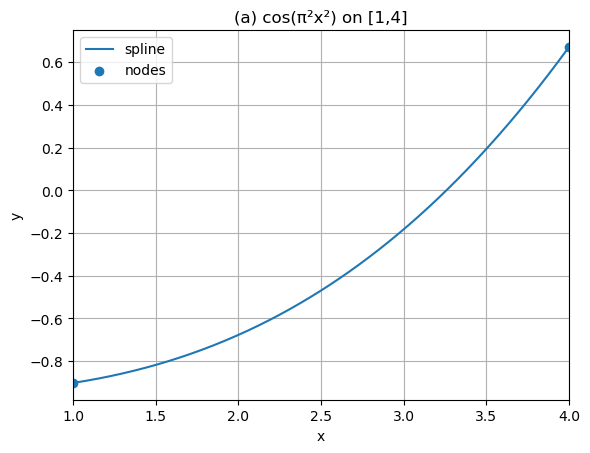

In [3]:
def modified_spinterp(t, y):
    """
    If number of nodes is 3, then use natural spline at t_0!

    Construct a cubic not-a-knot spline interpolating function for data
    values in `y` given at nodes in `t`.

    Parameters
    ----------
    t : 1-D array_like (length n+1, strictly increasing)
        Node vector.
    y : 1-D array_like (length n+1)
        Data values f(t_k).

    Returns
    -------
    S : callable
        S(x) evaluates the spline at x (scalar or NumPy array).

    Notes
    -----
    • Requires n >= 3 for non-degenerate not-a-knot conditions.  
    • The coefficient vector is ordered [a | b | c | d], each length n.
    """
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    n = t.size - 1
    # if n < 3:
    #     raise ValueError("Need at least 4 nodes (n >= 3 segments) for not-a-knot spline")

    h  = np.diff(t)                  # segment lengths (size n)
    Z  = np.zeros((n, n))
    I  = np.eye(n)
    E  = I[:-1, :]                   # deletes last row
    J  = I - np.diag(np.ones(n-1), k=1)   # diag(1) + super-diag(-1)
    H  = np.diag(h)
    H2 = np.diag(h**2)
    H3 = np.diag(h**3)

    # Assemble block rows (same order as original Julia code).
    AL  = np.hstack([I,  Z,    Z,    Z   ])
    AR  = np.hstack([I,  H,    H2,   H3  ])
    A1  = E @ np.hstack([Z,  J,  2*H, 3*H2])
    A2  = E @ np.hstack([Z,  Z,   J, 3*H ])
    nakL = np.zeros((1, 4*n))
    if n >= 3:
        nakL[0, 3*n   ] =  1
        nakL[0, 3*n+1 ] = -1  
    if n == 2:
        nakL[0, 2*n] = 1
    nakR = np.zeros((1, 4*n))
    nakR[0, 4*n-2 ] =  1
    nakR[0, 4*n-1 ] = -1

    A = np.vstack([AL, AR, A1, A2, nakL, nakR])
    v = np.concatenate([y[:-1], y[1:],            # vL, vR
                        np.zeros(n-1), np.zeros(n-1),  # v1, v2
                        [0.0, 0.0]])              # two not-a-knot RHS zeros

    # Solve for coefficients.
    z = np.linalg.solve(A, v)
    a, b, c, d = np.split(z, 4)

    # Evaluation routine (vectorised).
    def S(x):
        x = np.asarray(x, dtype=float)
        out = np.full_like(x, np.nan, dtype=float)

        m = (x >= t[0]) & (x <= t[-1])
        if not np.any(m):
            return out if out.shape else np.nan

        xi  = x[m]
        idx = np.searchsorted(t, xi, side='right') - 1   # segment indices
        idx[idx == n] = n-1                              # hit the last node
        s   = xi - t[idx]                                # local coordinate

        out[m] = a[idx] + s*(b[idx] + s*(c[idx] + s*d[idx]))
        return out if out.shape else out.item()

    return S

def plot_span(t, f, span_label=None):
    cs = modified_spinterp(t, f(t))
    xspan = np.linspace(t[1], t[2], 400)
    plt.figure()
    plt.plot(xspan, cs(xspan), label='spline')
    plt.scatter(t, f(t), marker='o', label='nodes')
    plt.xlim(t[1], t[2])
    plt.title(span_label or 'Cubic spline on sub-interval')
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)

plot_span(t_a, f, span_label='(a) cos(π²x²) on [1,4]')


## 3  Evenly-spaced nodes and comparison plot (cf. *Function 5.3.2*)
For each triple `(func, [a,b], n)` we build `n+1` equally spaced nodes, compute a spline, and overlay the graph of $f$.

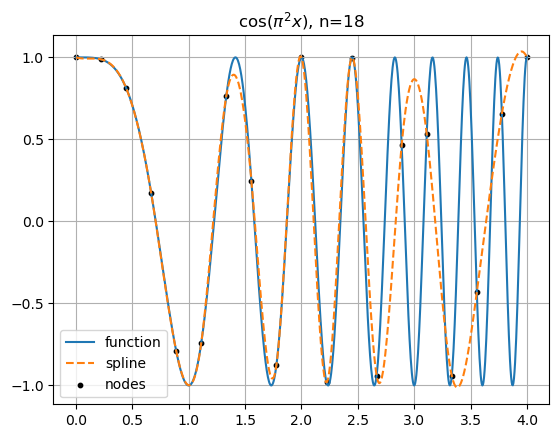

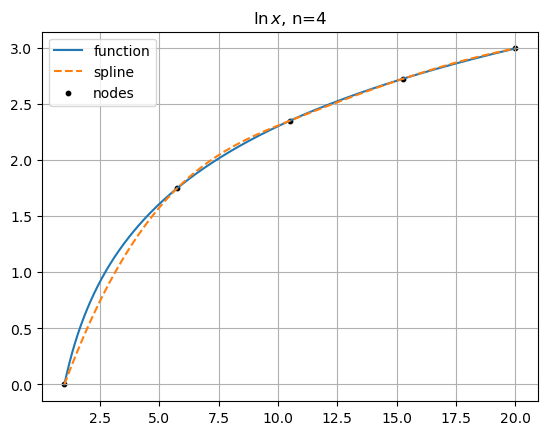

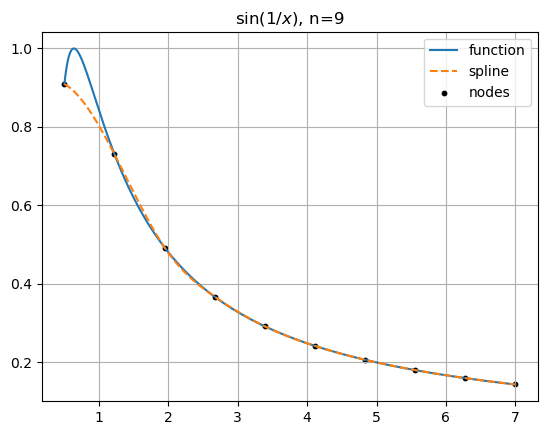

In [4]:
tests = [  # (function, interval, n, label)
    (lambda x: np.cos(np.pi * x**2), (0.0, 4.0), 18, r'$\cos(\pi^2 x)$'),
    (np.log, (1.0, 20.0), 4, r'$\ln x$'),
    (lambda x: np.sin(1.0/x), (0.5, 7.0), 9, r'$\sin(1/x)$'),
]

for f, (a,b), n, lbl in tests:
    t = np.linspace(a, b, n+1)
    cs = spinterp(t, f(t))
    fine = np.linspace(a, b, 800)
    plt.figure()
    plt.plot(fine, f(fine), label='function')
    plt.plot(fine, cs(fine), '--', label='spline')
    plt.scatter(t, f(t), c='k', s=10, label='nodes')
    plt.title(f'{lbl}, n={n}')
    plt.legend(); plt.grid(True)
    plt.show()

## 4  Piecewise linear interpolation error study
We approximate $E(n)=\|f-p\|_\infty$ on a dense uniform grid of 1600 points for increasing $n$.  The empirical rate is compared to the reference line $E=C n^{-4}$ on a log-log scale.

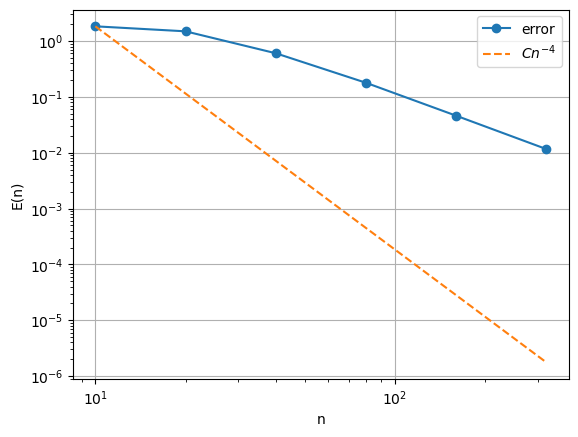

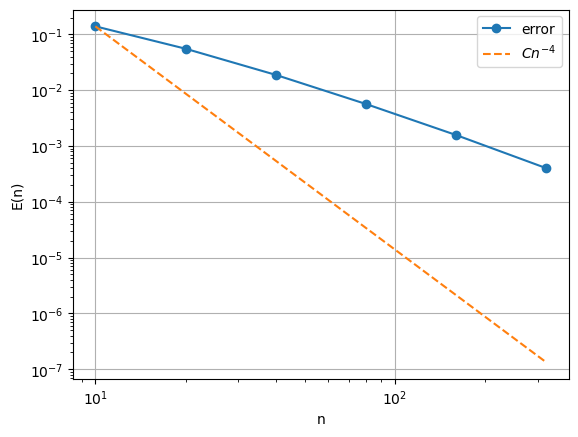

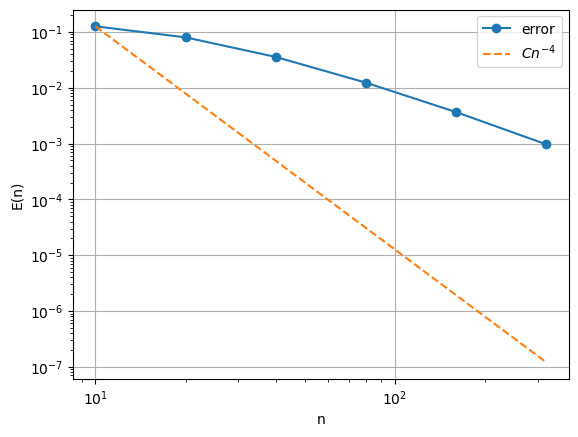

In [5]:
def pw_linear_error(f, a, b, ns):
    errs = []
    xs = np.linspace(a, b, 1600)
    for n in ns:
        t = np.linspace(a, b, n+1)
        p = np.interp(xs, t, f(t))
        errs.append(np.max(np.abs(f(xs) - p)))
    return np.array(errs)

cases = [ (lambda x: np.cos(np.pi * x**2), (0,4)),
          (np.log, (1,20)),
          (lambda x: np.sin(1/x), (0.5,7)) ]

ns = np.array([10, 20, 40, 80, 160, 320])

for f,(a,b) in cases:
    err = pw_linear_error(f,a,b,ns)
    C = err[0]*ns[0]**4     # crude fit using first point
    order = C*(1/ns.astype(np.float32)**4)
    plt.figure()
    plt.loglog(ns, err, 'o-', label='error')
    plt.loglog(ns, order, '--', label=r'$Cn^{-4}$')
    plt.xlabel('n')
    plt.ylabel('E(n)')
    plt.legend()
    plt.grid(True)
    plt.show()

## 5  Five cardinal cubic splines on $[0,1]$
The cardinal splines interpolate the standard basis vectors at the nodes given in the problem statement.

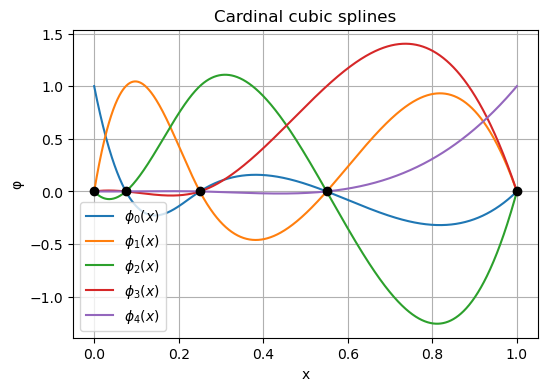

In [6]:
nodes = np.array([0, 0.075, 0.25, 0.55, 1.0])
m = len(nodes)
I = np.eye(m)
splines = [CubicSpline(nodes, I[:,k], bc_type='not-a-knot') for k in range(m)]

fine = np.linspace(0,1,1000)
plt.figure(figsize=(6,4))
for k,S in enumerate(splines):
    plt.plot(fine, S(fine), label=f'$\phi_{k}(x)$')
plt.plot(nodes, 0*nodes, 'o', color='black')
plt.xlabel('x')
plt.ylabel('φ')
plt.title('Cardinal cubic splines')
plt.legend()
plt.grid(True)
plt.show()

## 7 (b)  Periodic cubic spline interpolant of $\exp(\sin(3x))$
SciPy supports periodic end-conditions via `bc_type='periodic'`.  We apply this on $[0, 2\pi/3]$ with $n=8$ equally spaced nodes.

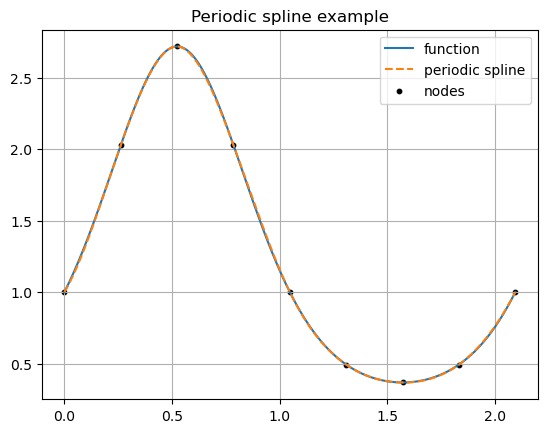

In [7]:
def modified_periodic_spinterp(t, y):
    """5-3
    Construct a cubic not-a-knot spline interpolating function for data
    values in `y` given at nodes in `t`.

    Parameters
    ----------
    t : 1-D array_like (length n+1, strictly increasing)
        Node vector.
    y : 1-D array_like (length n+1)
        Data values f(t_k).

    Returns
    -------
    S : callable
        S(x) evaluates the spline at x (scalar or NumPy array).

    Notes
    -----
    • Requires n >= 3 for non-degenerate not-a-knot conditions.  
    • The coefficient vector is ordered [a | b | c | d], each length n.
    """
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    n = t.size - 1
    # if n < 3:
    #     raise ValueError("Need at least 4 nodes (n >= 3 segments) for not-a-knot spline")

    h  = np.diff(t)                  # segment lengths (size n)
    Z  = np.zeros((n, n))
    I  = np.eye(n)
    E  = I[:-1, :]                   # deletes last row
    J  = I - np.diag(np.ones(n-1), k=1)   # diag(1) + super-diag(-1)
    H  = np.diag(h)
    H2 = np.diag(h**2)
    H3 = np.diag(h**3)

    # Assemble block rows (same order as original Julia code).
    AL  = np.hstack([I,  Z,    Z,    Z   ])
    AR  = np.hstack([I,  H,    H2,   H3  ])
    A1  = E @ np.hstack([Z,  J,  2*H, 3*H2])
    A2  = E @ np.hstack([Z,  Z,   J, 3*H ])

    P1 = np.zeros((1, 4*n))
    # index:    n,   2n-1, 3n-1, 4n-1
    # variable: b_0, b_n,  c_n,  d_n
    P1[0, [n, 2*n-1, 3*n-1, 4*n-1]] = [1, -1, -2*h[-1], -3*h[-1]**2]

    P2 = np.zeros((1, 4*n))
    # index:    2n,  3n-1, 4n-1
    # variable: c_0, c_n,  d_n
    P2[0, [2*n, 3*n-1, 4*n-1]] = [2, -2, 6*h[-1]]

    nakL = np.zeros((1, 4*n))
    nakL[0, 3*n   ] =  1
    nakL[0, 3*n+1 ] = -1
    nakR = np.zeros((1, 4*n))
    nakR[0, 4*n-2 ] =  1
    nakR[0, 4*n-1 ] = -1

    A = np.vstack([AL, AR, A1, A2, nakL, nakR])
    v = np.concatenate([y[:-1], y[1:],            # vL, vR
                        np.zeros(n-1), np.zeros(n-1),  # v1, v2
                        [0.0, 0.0]])              # two not-a-knot RHS zeros

    # Solve for coefficients.
    z = np.linalg.solve(A, v)
    a, b, c, d = np.split(z, 4)

    # Evaluation routine (vectorised).
    def S(x):
        x = np.asarray(x, dtype=float)
        out = np.full_like(x, np.nan, dtype=float)

        m = (x >= t[0]) & (x <= t[-1])
        if not np.any(m):
            return out if out.shape else np.nan

        xi  = x[m]
        idx = np.searchsorted(t, xi, side='right') - 1   # segment indices
        idx[idx == n] = n-1                              # hit the last node
        s   = xi - t[idx]                                # local coordinate

        out[m] = a[idx] + s*(b[idx] + s*(c[idx] + s*d[idx]))
        return out if out.shape else out.item()

    return S


f = lambda x: np.exp(np.sin(3*x))
a, b, n = 0.0, 2*np.pi/3, 8
t = np.linspace(a, b, n+1)
cs = modified_periodic_spinterp(t, f(t))
fine = np.linspace(a, b, 800)
plt.figure()
plt.plot(fine, f(fine), label='function')
plt.plot(fine, cs(fine), '--', label='periodic spline')
plt.scatter(t, f(t), c='k', s=10, label='nodes')
plt.legend()
plt.title('Periodic spline example')
plt.grid(True)
plt.show()